C:\Users\jesus\AppData\Local\Temp\ipykernel_35276\1163632385.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clients.groupby(["tenure_bin", "variation"], as_index=False)["cost_effective"]


=== Cost-Effectiveness Rate por Antigüedad y Grupo ===
  tenure_bin variation  cost_effective
0    <5 años   Control        0.415897
1    <5 años      Test        0.452454
2  5-10 años   Control        0.413297
3  5-10 años      Test        0.436465
4   >10 años   Control        0.410054
5   >10 años      Test        0.444318

=== Análisis de Cost-Effectiveness Rate por Antigüedad ===

Antigüedad: 5-10 años
   CE Rate (Test)    = 43.646%
   CE Rate (Control) = 41.330%
   z-stat = 2.5620, p-value = 0.010408
   -> Diferencia significativa (rechazamos H0).
   [Test: 2820 de 6461 clientes]
   [Control: 2300 de 5565 clientes]

Antigüedad: >10 años
   CE Rate (Test)    = 44.432%
   CE Rate (Control) = 41.005%
   z-stat = 4.4432, p-value = 0.000009
   -> Diferencia significativa (rechazamos H0).
   [Test: 3910 de 8800 clientes]
   [Control: 3173 de 7738 clientes]

Antigüedad: <5 años
   CE Rate (Test)    = 45.245%
   CE Rate (Control) = 41.590%
   z-stat = 2.9922, p-value = 0.002769
   -> Dif

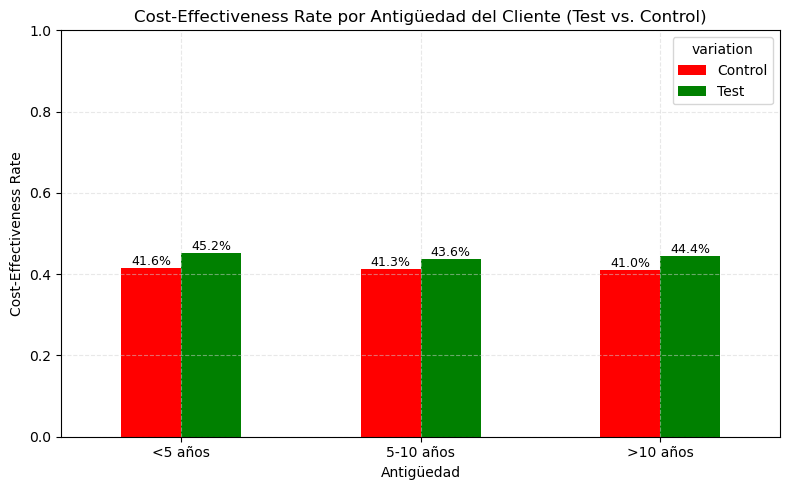

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --------------------------------------------------
# PASO 1: Cargar el DataFrame ya procesado
# --------------------------------------------------
df = pd.read_csv("../../data/processed/navegacion_clientes_experimento_limpio.csv")

# --------------------------------------------------
# PASO 2: Definir si el cliente completó el proceso (llegó a 'confirm')
# --------------------------------------------------
# 'completed' es True si process_step == "confirm"
df["completed"] = df["process_step"] == "confirm"

# --------------------------------------------------
# PASO 3: Agrupar a nivel de cliente (client_id, variation y antigüedad)
# --------------------------------------------------
# Para cada cliente, se marca como 'completed' si en alguna sesión llegó a confirm.
# Se conserva la antigüedad en años (clnt_tenure_yr), asumiendo que es constante por cliente.
df_clients = (
    df.groupby(["variation", "client_id"], as_index=False)
      .agg({
          "completed": "max",         # 1 si el cliente completó en alguna sesión
          "calls_6_mnth": "first",      # Valor de llamadas; se asume constante por cliente
          "clnt_tenure_yr": "first"     # Antigüedad en años
      })
)

# Filtrar para incluir sólo registros de "Control" y "Test"
df_clients = df_clients[df_clients["variation"].isin(["Control", "Test"])].copy()

# --------------------------------------------------
# PASO 4: Definir el umbral de coste y crear la variable "cost_effective"
# --------------------------------------------------
# Se considera rentable (cost-effective) al cliente si completó el proceso y realizó <= threshold_calls
threshold_calls = 3
df_clients["cost_effective"] = df_clients["completed"] & (df_clients["calls_6_mnth"] <= threshold_calls)

# --------------------------------------------------
# PASO 5: Crear categorías de antigüedad en el DataFrame de clientes
# --------------------------------------------------
# Definimos bins para la antigüedad (en años): por ejemplo, <5, 5-10, y >10 años.
bins_tenure = [0, 5, 10, np.inf]
labels_tenure = ["<5 años", "5-10 años", ">10 años"]
df_clients["tenure_bin"] = pd.cut(df_clients["clnt_tenure_yr"], bins=bins_tenure, labels=labels_tenure, include_lowest=True)

# --------------------------------------------------
# PASO 6: Calcular el Cost-Effectiveness Rate (CE Rate) por antigüedad y grupo
# --------------------------------------------------
df_ce_by_tenure = (
    df_clients.groupby(["tenure_bin", "variation"], as_index=False)["cost_effective"]
    .mean()  # La media equivale a la tasa de éxito rentable en cada segmento
)

print("=== Cost-Effectiveness Rate por Antigüedad y Grupo ===")
print(df_ce_by_tenure)

# --------------------------------------------------
# PASO 7: Test de hipótesis segmentado por antigüedad
# --------------------------------------------------
def proportion_test_for_tenure(seg_df):
    """
    Para un segmento de antigüedad, compara la tasa de éxito rentable entre Test y Control.
    """
    summary = seg_df.groupby("variation")["cost_effective"].agg(["mean", "sum", "count"])
    if not {"Test", "Control"}.issubset(summary.index):
        return None
    test_sum = summary.loc["Test", "sum"]
    test_n   = summary.loc["Test", "count"]
    ctrl_sum = summary.loc["Control", "sum"]
    ctrl_n   = summary.loc["Control", "count"]
    
    count = np.array([test_sum, ctrl_sum])
    nobs  = np.array([test_n, ctrl_n])
    stat, p_value = sm.stats.proportions_ztest(count, nobs, alternative='two-sided')
    
    return {
        "CE_Test": summary.loc["Test", "mean"],
        "CE_Control": summary.loc["Control", "mean"],
        "z_stat": stat,
        "p_value": p_value,
        "test_sum": test_sum,
        "test_n": test_n,
        "ctrl_sum": ctrl_sum,
        "ctrl_n": ctrl_n
    }

alpha = 0.05
tenure_bins_unique = df_clients["tenure_bin"].unique()

print("\n=== Análisis de Cost-Effectiveness Rate por Antigüedad ===\n")
for tenure in tenure_bins_unique:
    if pd.isna(tenure):
        continue
    seg_df = df_clients[df_clients["tenure_bin"] == tenure]
    result = proportion_test_for_tenure(seg_df)
    if result is None:
        print(f"Antigüedad {tenure}: Datos insuficientes para Test o Control.")
        continue
    print(f"Antigüedad: {tenure}")
    print(f"   CE Rate (Test)    = {result['CE_Test']:.3%}")
    print(f"   CE Rate (Control) = {result['CE_Control']:.3%}")
    print(f"   z-stat = {result['z_stat']:.4f}, p-value = {result['p_value']:.6f}")
    if result["p_value"] < alpha:
        print("   -> Diferencia significativa (rechazamos H0).")
    else:
        print("   -> No hay diferencia significativa (no rechazamos H0).")
    print(f"   [Test: {int(result['test_sum'])} de {int(result['test_n'])} clientes]")
    print(f"   [Control: {int(result['ctrl_sum'])} de {int(result['ctrl_n'])} clientes]\n")

# --------------------------------------------------
# PASO 8: Graficar el Cost-Effectiveness Rate por antigüedad
# --------------------------------------------------
# Convertir a tabla dinámica: filas = tenure_bin, columnas = variation.
df_pivot = df_ce_by_tenure.pivot(index="tenure_bin", columns="variation", values="cost_effective")

# Definir colores: Control en rojo, Test en verde.
color_map = {"Control": "red", "Test": "green", "Unknown": "gray"}
colors = [color_map.get(col, "gray") for col in df_pivot.columns]

fig, ax = plt.subplots(figsize=(8, 5))
df_pivot.plot(kind="bar", ax=ax, color=colors, legend=True)

ax.set_title("Cost-Effectiveness Rate por Antigüedad del Cliente (Test vs. Control)")
ax.set_xlabel("Antigüedad")
ax.set_ylabel("Cost-Effectiveness Rate")
ax.set_ylim(0, 1)

# Añadir rejilla con líneas discontinuas grises
ax.grid(True, which='major', axis='both', color='lightgray', linestyle='--', alpha=0.5)

# Añadir etiquetas de porcentaje sobre cada barra
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f"{height:.1%}",
                    (p.get_x() + p.get_width()/2, height),
                    ha="center", va="bottom", fontsize=9)

plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("../../img/ce_by_seniority.jpg", dpi=300, bbox_inches='tight')
plt.show()
